In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 13.0 MB/s eta 0:00:00


In [2]:
# !pip install muon_optimizer

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from torch.optim.lr_scheduler import *
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import numpy as np
from tqdm import tqdm
from einops import rearrange

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
torch.backends.cudnn.benchmark = True

# Dataset and DataLoader

In [6]:
dataroot = "/kaggle/input/50k-celeba-dataset-64x64"
dataset = datasets.ImageFolder(root=dataroot)
                           # transform=transforms.Compose([
                           #     transforms.Resize(image_size),
                           #     transforms.CenterCrop(image_size),
                           #     transforms.ToTensor(),
                           #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           # ]))

In [7]:
train_ds, test_ds = random_split(dataset, [0.8, 0.2])
train_ds, test_ds

(<torch.utils.data.dataset.Subset at 0x7898581b5090>,
 <torch.utils.data.dataset.Subset at 0x789858c46690>)

In [8]:
def collate_fn(batch):
    batch_size = len(batch)
    images = np.zeros((batch_size, 64, 64, 3)).astype(np.float32)
    labels = np.zeros(batch_size).astype(np.int32)
    cnt = 0
    for im, label in batch:
        # im = Image.open(pil_file)  
        im.draft('RGB',(64, 64))
        images[cnt] = np.asarray(im)
        labels[cnt] = label
        cnt += 1
    images = images.swapaxes(2, 3).swapaxes(1, 2) / 256
    return torch.from_numpy(images), torch.from_numpy(labels)

In [9]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
)
test_loader = DataLoader(
    test_ds,
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
)

In [10]:
%%time
for x in train_loader:
    print(x[0].shape)
    break

torch.Size([64, 3, 64, 64])
CPU times: user 30.5 ms, sys: 60.6 ms, total: 91.1 ms
Wall time: 705 ms


# Model Definition

In [11]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, upsample=False):
        super().__init__()
        if not upsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=stride, padding=1)
            self.skip = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=stride, padding=0)
        g = min(16, out_channels)
        self.gn1 = nn.GroupNorm(g, out_channels, eps=1e-3)
        self.gn2 = nn.GroupNorm(g, out_channels, eps=1e-3)
    def forward(self, x):
        x1 = F.silu(self.gn1(self.conv1(x)))
        x1 = F.silu(self.gn2(self.conv2(x1)))
        x = self.skip(x) + x1
        return x

In [12]:
class ViT(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.to_patch = nn.Conv2d(in_channels, 64, kernel_size=1, padding=0, stride=1)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=8,
            dim_feedforward=128,
            activation="gelu",
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2,
        )
        self.to_out = nn.Conv2d(64, out_channels, kernel_size=1, padding=0, stride=1)
    def forward(self, x):
        x = F.silu(self.to_patch(x))
        h = x.shape[2]
        w = x.shape[3]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.encoder(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.to_out(x)
        return x

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet_1 = ResNetBlock(3, 16, 1)
        self.resnet_2 = ResNetBlock(16, 32, 2)
        self.resnet_3 = ResNetBlock(32, 64, 2)
        self.resnet_4 = ResNetBlock(64, 128, 2)
        self.vit = nn.Sequential(
            ViT(64, 128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
        )
        self.to_mean = nn.Conv2d(128, 8, kernel_size=1, stride=1, padding=0)
        self.to_logstd = nn.Conv2d(128, 8, kernel_size=1, stride=1, padding=0)
    def forward(self, x):
        x = self.resnet_1(x)
        x = self.resnet_2(x)
        x = self.resnet_3(x)
        x = self.resnet_4(x) + self.vit(x)
        return self.to_mean(x), self.to_logstd(x)

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.to_in = nn.Conv2d(8, 128, kernel_size=1, stride=1, padding=0)
        self.vit = ViT(8, 128)
        self.resnet_1 = nn.Sequential(
            ResNetBlock(128, 128, 2, upsample=True),
            ResNetBlock(128, 64, 1),
        )
        self.resnet_2 = nn.Sequential(
            ResNetBlock(64, 64, 2, upsample=True),
            ResNetBlock(64, 32, 1),
        )
        self.resnet_3 = nn.Sequential(
            ResNetBlock(32, 32, 2, upsample=True),
            ResNetBlock(32, 16, 1),
        )
        self.resnet_4 = ResNetBlock(16, 3, 1)
    def forward(self, x):
        y = self.to_in(x) + self.vit(x)
        y = self.resnet_1(y)
        y = self.resnet_2(y)
        y = self.resnet_3(y)
        y = self.resnet_4(y)
        y = F.tanh(y)
        return y

In [15]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, img):
        mean_vals, log_std = self.encoder(img)
        # Obtain predicted mean and standard deviation
        std_vals = torch.exp(log_std)
        # Sample a normal distribution and then scale
        sampled_normal = torch.randn(mean_vals.shape).to(device)
        sampled_img = sampled_normal * std_vals + mean_vals
        # sampled_img = sampled_img.unsqueeze(1)
        # Pass the sampled through decoder
        pred = self.decoder(sampled_img)
        return mean_vals, std_vals, pred

In [16]:
model = VAE().to(device)

In [17]:
sum(p.numel() for p in model.parameters())

1566838

In [18]:
%%time
for x in train_loader:
    img = x[0].to(device)
    print(torch.max(img))
    mean, std, pred = model(img)
    print(mean.shape)
    print(std.shape)
    print(pred.shape)
    break

tensor(0.9961, device='cuda:0')
torch.Size([64, 8, 8, 8])
torch.Size([64, 8, 8, 8])
torch.Size([64, 3, 64, 64])
CPU times: user 1.14 s, sys: 525 ms, total: 1.66 s
Wall time: 2.58 s


# Training

In [19]:
from tqdm import tqdm

In [20]:
kl_weight = 1e-6

In [21]:
def train():
    model.train()
    total_loss = 0
    cnt = 0
    t_recon_loss = 0
    t_kl_div_loss = 0
    for x in (pbar := tqdm(train_loader)):
        img = x[0].to(device)
        img = img * 2 - 1
        mean_vals, std_vals, pred = model(img)
        # Compute Losses
        recon_loss = criteria(pred, img) # Reconstruction loss
        kl_div_loss = torch.sum(torch.square(mean_vals) + torch.square(std_vals) - 2 * torch.log(torch.abs(std_vals) + 1e-6))
        # FID Loss
        
        # Sum them
        loss = recon_loss + kl_div_loss * kl_weight
        total_loss += loss.item()
        t_recon_loss += recon_loss.item()
        t_kl_div_loss += kl_div_loss * kl_weight
        cnt += 1
        # Back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update tqdm
        pbar.set_description(f"Average Loss: {total_loss / cnt :6f}")
    print(f"Reconstruction Loss to KL Divergence Loss: {t_recon_loss / t_kl_div_loss : 6f}")
    if scheduler is not None:
        scheduler.step()

In [22]:
def test():
    model.eval()
    total_loss = 0
    cnt = 0
    with torch.no_grad():
        for x in (pbar := tqdm(test_loader)):
            img = x[0].to(device)
            img = img * 2 - 1
            mean_vals, std_vals, pred = model(img)
            # Compute Losses
            recon_loss = criteria(pred, img) # Reconstruction loss
            kl_div_loss = torch.sum(torch.square(mean_vals) + torch.square(std_vals) - 2 * torch.log(torch.abs(std_vals) + 1e-6))
            # Sum them
            loss = recon_loss + kl_div_loss * kl_weight
            total_loss += loss.item()
            cnt += 1
            # Update tqdm
            pbar.set_description(f"Testing: Average Loss: {total_loss / cnt :6f}")

In [23]:
import matplotlib.pyplot as plt

def generate_image(num_image=1):
    model.eval()
    with torch.no_grad():
        sample_noise = torch.randn(num_image, 8, 8, 8).to(device)
        sample_noise = torch.clamp(sample_noise, -3, 3)
        pred = model.decoder(sample_noise)
        pred = (pred + 1) / 2
    return pred.detach().cpu().squeeze()

def generate_w_grad(num_image=64):
    model.train()
    sample_noise = torch.randn(num_image, 8, 8, 8).to(device)
    sample_noise.requires_grad = False
    sample_noise = torch.clamp(sample_noise, -3, 3)
    pred = model.decoder(sample_noise)
    pred = (pred + 1) / 2
    return pred

# Model Definition and Optimizers

In [24]:
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [25]:
class MultipleScheduler(object):
    def __init__(self, *op):
        self.schedulers = op

    def step(self):
        for op in self.schedulers:
            op.step()

In [26]:
from torch.optim import *
from torch.optim.lr_scheduler import *
# from muon import SingleDeviceMuon

## Muon

In [27]:
def zeropower_via_newtonschulz5(G, steps: int):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert G.ndim >= 2 # batched Muon implementation by @scottjmaddox, and put into practice in the record by @YouJiacheng
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A # quintic computation strategy adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X
    
    if G.size(-2) > G.size(-1):
        X = X.mT
    return X


def muon_update(grad, momentum, beta=0.95, ns_steps=5, nesterov=True):
    momentum.lerp_(grad, 1 - beta)
    update = grad.lerp_(momentum, beta) if nesterov else momentum
    if update.ndim == 4: # for the case of conv filters
        update = update.view(len(update), -1)
    update = zeropower_via_newtonschulz5(update, steps=ns_steps)
    update *= max(1, grad.size(-2) / grad.size(-1))**0.5
    return update

In [28]:
class SingleDeviceMuon(torch.optim.Optimizer):
    """
    Muon variant for usage in non-distributed settings.
    """
    def __init__(self, params, lr=0.02, weight_decay=0, momentum=0.95):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                if len(state) == 0:
                    state["momentum_buffer"] = torch.zeros_like(p)
                if p.grad is not None:
                    update = muon_update(p.grad, state["momentum_buffer"], beta=group["momentum"])
                    p.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update.reshape(p.shape), alpha=-group["lr"])

## SPlus

In [29]:
import torch
from torch.optim.optimizer import Optimizer
from typing import Any

class SPlus(Optimizer):

    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
        b2: float = 0.999,
        ema_rate: float = 0.999,
        inverse_every: int = 100,
        eps: float = 1e-30,
        weight_decay: float = 1e-2,
        max_dim: int = 10000,
        nonstandard_constant: float = 0.001,
    ):
        defaults = dict(
            lr=lr,
            b1=b1,
            b2=b2,
            ema_rate=ema_rate,
            inverse_every=inverse_every,
            weight_decay=weight_decay,
            eps=eps,
            max_dim=max_dim,
            nonstandard_constant=nonstandard_constant,
        )
        super(SPlus, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            for p in group["params"]:
                p_state = self.state.get(p, [])
                step_val = float(p_state["step"])
                p_state["step"] = torch.tensor(step_val)

    @torch.no_grad()
    def eval(self): # Sets parameters to EMA values for evaluation.
        for group in self.param_groups:
            if 'train_mode' in group:
                train_mode = group['train_mode']
                ema_rate = group['ema_rate']
                if train_mode:
                    for p in group['params']:
                        state = self.state[p]
                        state['param_buffer'] = p.clone()
                        p.lerp_(state['ema'], 1)
                        p.mul_(1 / (1 - ema_rate ** state['step']))
                    group['train_mode'] = False

    @torch.no_grad()
    def train(self): # Resets parameters back from buffer.
        for group in self.param_groups:
            if 'train_mode' in group:
                train_mode = group['train_mode']
                if not train_mode:
                    for p in group['params']:
                        state = self.state[p]
                        if 'param_buffer' in state:
                            p.lerp_(state['param_buffer'], 1) # p.copy_(state['param_buffer'])
                            del state['param_buffer']
                    group['train_mode'] = True

    @torch.no_grad()
    def step(self, closure = None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['ema'] = torch.zeros_like(p)
                    group['train_mode'] = True
                    if len(p.shape) == 2:
                        state['sides'] = [torch.zeros((d, d), device=p.device) if d < group['max_dim'] else None for d in p.shape]
                        state['q_sides'] = [torch.eye(d, device=p.device) if d < group['max_dim'] else None for d in p.shape]

                # Shape-dependent scaling
                if len(p.shape) != 2 or p.shape[0] > group['max_dim'] or p.shape[1] > group['max_dim']:
                    scaled_lr = group['lr'] * group['nonstandard_constant']
                else:
                    scaled_lr = group['lr'] * (2 / (p.shape[0] + p.shape[1]))

                # Main splus update
                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])
                if len(p.shape) == 2:
                    m = state['q_sides'][0].T @ m if state['q_sides'][0] is not None else m
                    m = m @ state['q_sides'][1] if state['q_sides'][1] is not None else m
                    state['sides'][0] = torch.lerp(state['sides'][0], grad @ grad.T, 1 - group['b2']) if state['sides'][0] is not None else None
                    state['sides'][1] = torch.lerp(state['sides'][1], grad.T @ grad, 1 - group['b2']) if state['sides'][1] is not None else None
                    u = torch.sign(m)
                    u = state['q_sides'][0] @ u if state['q_sides'][0] is not None else u
                    u = u @ state['q_sides'][1].T if state['q_sides'][1] is not None else u

                    # Every `inverse_every` steps, we update the inverse eigendecomposition.
                    if state['step'] == 1 or state['step'] % group['inverse_every'] == 0:
                        if state['sides'][0] is not None:
                            _, eigvecs = torch.linalg.eigh(state['sides'][0] + group['eps'] * torch.eye(state['sides'][0].shape[0], device=p.device))
                            state['q_sides'][0] = eigvecs
                        if state['sides'][1] is not None:
                            _, eigvecs = torch.linalg.eigh(state['sides'][1] + group['eps'] * torch.eye(state['sides'][1].shape[0], device=p.device))
                            state['q_sides'][1] = eigvecs
                else:
                    u = torch.sign(m)

                p.add_(u, alpha=-scaled_lr)
                state['ema'].lerp_(p, 1 - group['ema_rate'])
                p.mul_(1 - scaled_lr * group["weight_decay"])

        return loss

## FID Loss

In [30]:
import torch
from torch.autograd import Function
import numpy as np
import scipy.linalg


class MatrixSquareRoot(Function):
    """Square root of a positive definite matrix.

    NOTE: matrix square root is not differentiable for matrices with
          zero eigenvalues.
    """
    @staticmethod
    def forward(ctx, input):
        m = input.detach().cpu().numpy().astype(np.float_)
        sqrtm = torch.from_numpy(scipy.linalg.sqrtm(m).real).to(input)
        ctx.save_for_backward(sqrtm)
        return sqrtm

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        if ctx.needs_input_grad[0]:
            sqrtm, = ctx.saved_tensors
            sqrtm = sqrtm.data.cpu().numpy().astype(np.float_)
            gm = grad_output.data.cpu().numpy().astype(np.float_)

            # Given a positive semi-definite matrix X,
            # since X = X^{1/2}X^{1/2}, we can compute the gradient of the
            # matrix square root dX^{1/2} by solving the Sylvester equation:
            # dX = (d(X^{1/2})X^{1/2} + X^{1/2}(dX^{1/2}).
            grad_sqrtm = scipy.linalg.solve_sylvester(sqrtm, sqrtm, gm)

            grad_input = torch.from_numpy(grad_sqrtm).to(grad_output)
        return grad_input


sqrtm = MatrixSquareRoot.apply

In [31]:
import torch
from torch import nn
from torchvision.models import inception_v3
import cv2
import multiprocessing
import numpy as np
import glob
import os
from scipy import linalg


def to_cuda(elements):
    """
    Transfers elements to cuda if GPU is available
    Args:
        elements: torch.tensor or torch.nn.module
        --
    Returns:
        elements: same as input on GPU memory, if available
    """
    if torch.cuda.is_available():
        return elements.cuda()
    return elements


class PartialInceptionNetwork(nn.Module):

    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

    def forward(self, x):
        """
        Args:
            x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
        Returns:
            inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
        """
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)

        x = x * 2 - 1 # Normalize to [-1, 1]

        # Trigger output hook
        self.inception_network(x)

        # Output: N x 2048 x 1 x 1 
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations

inception_network = PartialInceptionNetwork()
inception_network = to_cuda(inception_network)
inception_network.eval()
for p in inception_network.parameters(): 
    p.requires_grad_(False)

from torchvision.transforms import Resize
inception_resize = Resize(size=(299, 299))

def get_activations(images, batch_size):
    """
    Calculates activations for last pool layer for all iamges
    --
        Images: torch.array shape: (N, 3, 299, 299), dtype: torch.float32
        batch size: batch size used for inception network
    --
    Returns: np array shape: (N, 2048), dtype: np.float32
    """

    images = inception_resize(images)
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)

    num_images = images.shape[0]
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = torch.zeros((num_images, 2048), dtype=torch.float32).to(device)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        # ims = to_cuda(ims)
        activations = inception_network(ims)
        # activations = activations
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations



def calculate_activation_statistics(images, batch_size):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer 
                of the inception model.

    """
    act = get_activations(images, batch_size)
    # print(act)
    mu = torch.mean(act, axis=0)
    sigma = torch.cov(act.permute(0, 1))
    return mu, sigma


# Modified from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive resources set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive resources set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = torch.atleast_1d(mu1)
    mu2 = torch.atleast_1d(mu2)

    sigma1 = torch.atleast_2d(sigma1)
    sigma2 = torch.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean = sqrtm(sigma1 @ sigma2)
    if not torch.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = torch.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if torch.is_complex(covmean):
        if not torch.allclose(torch.diagonal(covmean).imag, 0, atol=1e-3):
            m = torch.max(torch.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = torch.trace(covmean)

    return diff.dot(diff) + torch.trace(sigma1) + torch.trace(sigma2) - 2 * tr_covmean

def calculate_fid(images1, images2, batch_size=64):
    """ Calculate FID between images1 and images2
    Args:
        images1: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        images2: np.array, shape: (N, H, W, 3), dtype: np.float32 between 0-1 or np.uint8
        use_multiprocessing: If multiprocessing should be used to pre-process the images
        batch size: batch size used for inception network
    Returns:
        FID (scalar)
    """
    mu1, sigma1 = calculate_activation_statistics(images1, batch_size)
    mu2, sigma2 = calculate_activation_statistics(images2, batch_size)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 211MB/s] 


In [32]:
# idl = iter(train_loader)
# for i in tqdm(range(1)):
#     reals = ((next(idl))[0] * 1).to(device)

# for i in tqdm(range(1)):
#     fakes = generate_w_grad(num_image=64)
#     fakes = torch.clamp(fakes, 0, 1)

In [33]:
# enable memory history, which will
# add tracebacks and event history to snapshots
# torch.cuda.memory._record_memory_history()

In [34]:
# %%time
# calculate_fid(reals[:2], fakes[:2], 2)

In [35]:
# torch.cuda.memory._dump_snapshot("my_snapshot.pickle")

In [36]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [37]:
def symmetric_matrix_sqrt(A):
    # A: (D,D), symmetric PSD
    eigval, eigvec = torch.linalg.eigh(A + 1e-6)
    eigval = torch.clamp(eigval, min=1e-8)
    sqrt_eig = torch.sqrt(eigval)
    # V diag(sqrt) Vᵀ
    return eigvec @ (sqrt_eig.unsqueeze(-2) * eigvec.transpose(-2,-1))

In [38]:
from mpmath import *
import numpy as np
import torch

mp.dps = 32
one = mpf(1)
mp.pretty = True

def f(x):
    return sqrt(one-x)

# Derive the taylor and pade' coefficients for MTP, MPA
a = taylor(f, 0, 10)
pade_p, pade_q = pade(a, 5, 5)
a = torch.from_numpy(np.array(a).astype(float))
pade_p = torch.from_numpy(np.array(pade_p).astype(float))
pade_q = torch.from_numpy(np.array(pade_q).astype(float))

def matrix_taylor_polynomial(p, I):
    p_sqrt= I
    p_app = I - p
    p_hat = p_app
    for i in range(10):
      p_sqrt += a[i+1]*p_hat
      p_hat = p_hat.bmm(p_app)
    return p_sqrt

def matrix_pade_approximant(p,I):
    p_sqrt = pade_p[0]*I
    q_sqrt = pade_q[0]*I
    p_app = I - p
    p_hat = p_app
    for i in range(5):
        p_sqrt += pade_p[i+1]*p_hat
        q_sqrt += pade_q[i+1]*p_hat
        p_hat = p_hat.bmm(p_app)
    #There are 4 options to compute the MPA: comput Matrix Inverse or Matrix Linear System on CPU/GPU;
    #It seems that single matrix is faster on CPU and batched matrices are faster on GPU
    #Please check which one is faster before running the code;
    return torch.linalg.solve(q_sqrt, p_sqrt)
    #return torch.linalg.solve(q_sqrt.cpu(), p_sqrt.cpu()).cuda()
    #return torch.linalg.inv(q_sqrt).mm(p_sqrt)
    #return torch.linalg.inv(q_sqrt.cpu()).cuda().bmm(p_sqrt)

def matrix_pade_approximant_inverse(p,I):
    p_sqrt = pade_p[0]*I
    q_sqrt = pade_q[0]*I
    p_app = I - p
    p_hat = p_app
    for i in range(5):
        p_sqrt += pade_p[i+1]*p_hat
        q_sqrt += pade_q[i+1]*p_hat
        p_hat = p_hat.bmm(p_app)
    #There are 4 options to compute the MPA_inverse: comput Matrix Inverse or Matrix Linear System on CPU/GPU;
    #It seems that single matrix is faster on CPU and batched matrices are faster on GPU
    #Please check which one is faster before running the code;
    return torch.linalg.solve(p_sqrt, q_sqrt)
    #return torch.linalg.solve(p_sqrt.cpu(), q_sqrt.cpu()).cuda()
    #return torch.linalg.inv(p_sqrt).mm(q_sqrt)
    #return torch.linalg.inv(p_sqrt.cpu()).cuda().bmm(q_sqrt)

#Differentiable Matrix Square Root by MPA_Lya
class MPA_Lya(torch.autograd.Function):
    @staticmethod
    def forward(ctx, M):
        normM = torch.norm(M,dim=[1,2]).reshape(M.size(0),1,1)
        I = torch.eye(M.size(1), requires_grad=False, device=M.device).reshape(1,M.size(1),M.size(1)).repeat(M.size(0),1,1)
        #This is for MTP calculation
        #M_sqrt = matrix_taylor_polynomial(M/normM,I)
        M_sqrt = matrix_pade_approximant(M / normM, I)
        M_sqrt = M_sqrt * torch.sqrt(normM)
        ctx.save_for_backward(M, M_sqrt, normM,  I)
        return M_sqrt

    @staticmethod
    def backward(ctx, grad_output):
        M, M_sqrt, normM,  I = ctx.saved_tensors
        b = M_sqrt / torch.sqrt(normM)
        c = grad_output / torch.sqrt(normM)
        for i in range(8):
            #In case you might terminate the iteration by checking convergence
            #if th.norm(b-I)<1e-4:
            #    break
            b_2 = b.bmm(b)
            c = 0.5 * (c.bmm(3.0*I-b_2)-b_2.bmm(c)+b.bmm(c).bmm(b))
            b = 0.5 * b.bmm(3.0 * I - b_2)
        grad_input = 0.5 * c
        return grad_input

#Differentiable Inverse Square Root by MPA_Lya_Inv
class MPA_Lya_Inv(torch.autograd.Function):
    @staticmethod
    def forward(ctx, M):
        normM = torch.norm(M,dim=[1,2]).reshape(M.size(0),1,1)
        I = torch.eye(M.size(1), requires_grad=False, device=M.device).reshape(1,M.size(1),M.size(1)).repeat(M.size(0),1,1)
        #M_sqrt = matrix_taylor_polynomial(M/normM,I)
        M_sqrt_inv = matrix_pade_approximant_inverse(M / normM, I)
        M_sqrt_inv = M_sqrt_inv / torch.sqrt(normM)
        ctx.save_for_backward(M, M_sqrt_inv,  I)
        return M_sqrt_inv

    @staticmethod
    def backward(ctx, grad_output):
        M, M_sqrt_inv,  I = ctx.saved_tensors
        M_inv = M_sqrt_inv.bmm(M_sqrt_inv)
        grad_lya = - M_inv.bmm(grad_output).bmm(M_inv)
        norm_sqrt_inv = torch.norm(M_sqrt_inv)
        b = M_sqrt_inv / norm_sqrt_inv
        c = grad_lya / norm_sqrt_inv
        for i in range(8):
            #In case you might terminate the iteration by checking convergence
            #if th.norm(b-I)<1e-4:
            #    break
            b_2 = b.bmm(b)
            c = 0.5 * (c.bmm(3.0 * I - b_2) - b_2.bmm(c) + b.bmm(c).bmm(b))
            b = 0.5 * b.bmm(3.0 * I - b_2)
        grad_input = 0.5 * c
        return grad_input

In [39]:
FastMatSqrt = MPA_Lya.apply

In [40]:
def train_fid_loss(num_batches=10):
    model.train()
    idl = iter(train_loader)
    reals = ((next(idl))[0] * 1).to(device)
    for i in range(num_batches - 1):
        new_reals = ((next(idl))[0] * 1).to(device)
        reals = torch.cat([reals, new_reals], dim=0)
    reals = inception_resize(reals).to(device)
    # total_loss = 0
    for i in tqdm(range(0, 64 * num_batches, 8)):
        real_images = reals[i:i+8]
        fake_images = generate_w_grad(num_image=8)
        if torch.isnan(fake_images).any():
            fake_images = generate_w_grad(num_image=8)
        # print(fake_images[0])
        fake_images = torch.clamp(fake_images, 0, 1)
        fake_images = inception_resize(fake_images).to(device)
        # 2) Compute 2048‑d features in one forward per batch
        feats_real = inception_network(real_images)   # → (B,2048)
        feats_fake = inception_network(fake_images)   # → (B,2048)
    
        # 3) Batch‑wise μ & Σ (differentiable)
        mu_r    = feats_real.mean(dim=0)
        mu_f    = feats_fake.mean(dim=0)
        x_r     = feats_real - mu_r
        x_f     = feats_fake - mu_f
        sigma_r = x_r.T @ x_r / (8 - 1)
        sigma_f = x_f.T @ x_f / (8 - 1)
    
        # 4) Compute the symmetric sqrt of Σ_r Σ_f on GPU
        covmean = FastMatSqrt((sigma_r @ sigma_f).unsqueeze(0)).squeeze()
    
        # 5) FID² as your loss
        diff   = mu_r - mu_f
        fid2   = diff.dot(diff) + torch.trace(sigma_r) + torch.trace(sigma_f) - 2 * torch.trace(covmean)
        fid2 = fid2 * 1e-3
        # total_loss += fid2
        fid_optimizer.zero_grad()
        fid2.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        fid_optimizer.step()
    # fid_optimizer.zero_grad()
    # total_loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    # fid_optimizer.step()

In [41]:
# train_fid_loss()

## Training

In [60]:
model = VAE().to(device)

In [61]:
sum(p.numel() for p in model.parameters())

1566838

In [62]:
criteria = nn.MSELoss()
# criteria = nn.L1Loss()
# optimizer = AdamW(model.parameters(), lr=1e-4)
# optimizer = SGD(model.parameters(), lr=1e-4, momentum=0.9)
optimizer = SPlus(model.parameters(), lr=0.2)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [63]:
hidden_weights = [p for p in model.parameters() if p.ndim >= 2]
hidden_gains_biases = [p for p in model.parameters() if p.ndim < 2]

In [64]:
# for name, p in model.named_parameters():
#     print(p.ndim)
#     print(p.shape)
#     print(name)
#     break

In [65]:
param_groups = [
    dict(params=hidden_weights, use_muon=True,
         lr=1e-2, weight_decay=0, momentum=0.95, nesterov=True),
]
muon_optimizer = SingleDeviceMuon(param_groups)
muon_scheduler = ExponentialLR(muon_optimizer, gamma=0.8)
param_groups = [
    dict(params=hidden_gains_biases, lr=3e-4, weight_decay=0),
]
adamw_optimizer = AdamW(param_groups)
adamw_scheduler = ExponentialLR(adamw_optimizer, gamma=0.8)

In [66]:
optimizer = MultipleOptimizer(muon_optimizer, adamw_optimizer)
scheduler = MultipleScheduler(muon_scheduler, adamw_scheduler)

In [67]:
fid_optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0)

In [68]:
# for p in model.parameters():
#     p.register_hook(lambda grad: torch.clamp(grad, -1e-0, 1e-0))

In [69]:
for i in range(5):
    # kl_weight = 1e-6 * (i + 2) / 2
    kl_weight = 5e-6
    # optimizer.train()
    train()
    # train_fid_loss(num_batches=10)
    # optimizer.eval()
    test()

# with torch.autograd.set_detect_anomaly(True):

Average Loss: 0.274248: 100%|██████████| 625/625 [01:14<00:00,  8.38it/s]


Reconstruction Loss to KL Divergence Loss:  0.384564


Average Loss: 0.253161: 100%|██████████| 625/625 [01:13<00:00,  8.45it/s]


Reconstruction Loss to KL Divergence Loss:  0.296834


Average Loss: 0.250330: 100%|██████████| 625/625 [01:13<00:00,  8.45it/s]


Reconstruction Loss to KL Divergence Loss:  0.287248


Average Loss: 0.248567: 100%|██████████| 625/625 [01:14<00:00,  8.43it/s]


Reconstruction Loss to KL Divergence Loss:  0.282309


Average Loss: 0.247118: 100%|██████████| 625/625 [01:14<00:00,  8.39it/s]


Reconstruction Loss to KL Divergence Loss:  0.278977


Testing: Average Loss: 0.435088: 100%|██████████| 79/79 [00:04<00:00, 17.53it/s]


In [78]:
train_fid_loss()
train_fid_loss()

 85%|████████▌ | 68/80 [00:16<00:02,  4.18it/s]


KeyboardInterrupt: 

In [79]:
for x, _ in test_loader:
    img = x.to(device)
    img = img * 2 - 1
    _, _, output = model(img)
    output = (output + 1) / 2
    break

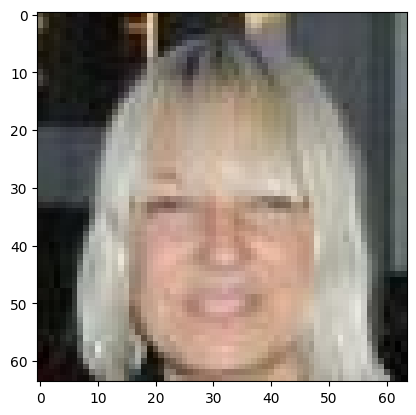

In [80]:
plt.imshow(x[0].permute(1, 2, 0))

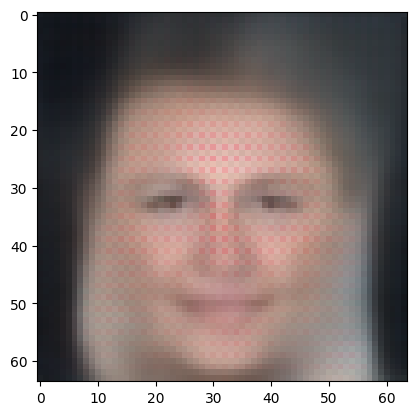

In [81]:
plt.imshow(output[0].detach().cpu().permute(1, 2, 0))

In [82]:
img = generate_image().permute(1, 2, 0)

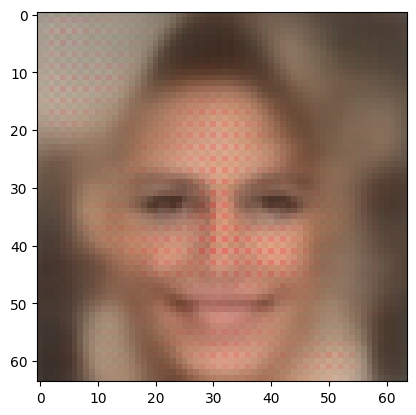

In [83]:
plt.imshow(img)

# FID Computation

In [84]:
from torcheval.metrics import FrechetInceptionDistance
fid = FrechetInceptionDistance(device = "cuda")

idl = iter(train_loader)
for i in tqdm(range(4)):
    reals = ((next(idl))[0] * 1).to(device)
    fid.update(reals, True)

for i in tqdm(range(4)):
    fakes = generate_image(num_image=64)
    fakes = torch.clamp(fakes, 0, 1)
    fid.update(fakes, False)

100%|██████████| 4/4 [00:00<00:00,  7.13it/s]


In [85]:
fid.compute()

tensor(156.6248, device='cuda:0')